# Junien nopeus- ja kiihtyvyystarkasteluja

In [1]:
import sqlite3
from pathlib import Path

import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# main_path = "https://rata.digitraffic.fi/api/v1/trains/"

In [3]:
# testi = "https://rata.digitraffic.fi/api/v1/train-locations/latest/"

Haetaan Helsingistä Ouluun kulkevat junat 14.3.2023

In [4]:
url_start = "https://rata.digitraffic.fi/api/v1/live-trains/"

depart = "HKI"
arrive = "OL"

date = "2023-03-14"

url = f"{url_start}station/{depart}/{arrive}?departure_date={date}"

In [5]:
req = requests.get(url)
req.status_code

200

In [6]:
trains = req.json()
len(trains)

13

In [7]:
train_nums = [train["trainNumber"] for train in trains]
len(train_nums)

13

In [8]:
train_nums

[35, 21, 23, 65, 25, 37, 67, 27, 51, 29, 265, 269, 273]

In [9]:
train_num = 35

In [10]:
teh_train = list(filter(lambda t: t["trainNumber"] == train_num, trains))[0]

In [11]:
list(filter(lambda d: d["stationShortCode"] == "OL", teh_train["timeTableRows"]))[0]

{'stationShortCode': 'OL',
 'stationUICCode': 370,
 'countryCode': 'FI',
 'type': 'ARRIVAL',
 'trainStopping': True,
 'commercialStop': True,
 'commercialTrack': '2',
 'cancelled': False,
 'scheduledTime': '2023-03-14T09:42:00.000Z',
 'trainNumber': 35}

Katsotaan junan 35 nopeuksia ja kiihtyvyyksiä

In [12]:
train_num = train_nums[0]
# onhan se varmasti
print(train_num)

35


In [13]:
url_start = "https://rata.digitraffic.fi/api/v1/train-locations/"

# date = "2023-03-14"
# train_num = 1

url = f"{url_start}{date}/{train_num}"

In [14]:
req = requests.get(url)
req.status_code

200

In [15]:
data = pd.DataFrame(req.json())

# aikamuodot kuntoon
data["timestamp"] = pd.to_datetime(data["timestamp"])
data["duration"] = (data["timestamp"] - data["timestamp"].min()).apply(lambda t: t.total_seconds())

# koordinaatit talteen (ja vanhat pois)
data["latitude"] = data["location"].apply(lambda d: d["coordinates"][1])
data["longitude"] = data["location"].apply(lambda d: d["coordinates"][0])
data.drop("location", inplace=True, axis=1)

data.drop(["trainNumber", "departureDate"], inplace=True, axis=1)

# onko sorttaus paikallaan?
data = data.sort_values("duration").reset_index(drop=True)
pd.concat([data.head(3), data.tail(3)])

,timestamp,speed,accuracy,duration,latitude,longitude
0,2023-03-14 02:50:30+00:00,0,4,0.0,60.173204,24.941432
1,2023-03-14 02:50:36+00:00,0,4,6.0,60.173204,24.941432
2,2023-03-14 02:50:42+00:00,0,4,12.0,60.173204,24.941432
4025,2023-03-14 09:42:44+00:00,66,0,24734.0,65.010667,25.484247
4026,2023-03-14 09:42:50+00:00,66,0,24740.0,65.010079,25.483856
4027,2023-03-14 09:42:56+00:00,66,0,24746.0,65.010079,25.483856


Lisätään vanhat koordinaatit etäisyystarkistyksia varten

In [16]:
prev_lat = [data.loc[0, "latitude"]]
prev_lat = prev_lat + list(data.loc[:len(data.index)-2, "latitude"])
data["previous_latitude"] = prev_lat

prev_lon = [data.loc[0, "longitude"]]
prev_lon = prev_lon + list(data.loc[:len(data.index)-2, "longitude"])
data["previous_longitude"] = prev_lon

pd.concat([data.head(3), data.tail(3)])

,timestamp,speed,accuracy,duration,latitude,longitude,previous_latitude,previous_longitude
0,2023-03-14 02:50:30+00:00,0,4,0.0,60.173204,24.941432,60.173204,24.941432
1,2023-03-14 02:50:36+00:00,0,4,6.0,60.173204,24.941432,60.173204,24.941432
2,2023-03-14 02:50:42+00:00,0,4,12.0,60.173204,24.941432,60.173204,24.941432
4025,2023-03-14 09:42:44+00:00,66,0,24734.0,65.010667,25.484247,65.010795,25.484494
4026,2023-03-14 09:42:50+00:00,66,0,24740.0,65.010079,25.483856,65.010667,25.484247
4027,2023-03-14 09:42:56+00:00,66,0,24746.0,65.010079,25.483856,65.010079,25.483856


In [17]:
data.tail(10)

,timestamp,speed,accuracy,duration,latitude,longitude,previous_latitude,previous_longitude
4018,2023-03-14 09:42:02+00:00,66,0,24692.0,65.010689,25.483736,65.010380,25.483435
4019,2023-03-14 09:42:08+00:00,66,0,24698.0,65.011269,25.484361,65.010689,25.483736
4020,2023-03-14 09:42:14+00:00,66,0,24704.0,65.010990,25.484292,65.011269,25.484361
4021,2023-03-14 09:42:20+00:00,66,0,24710.0,65.010982,25.484356,65.010990,25.484292
4022,2023-03-14 09:42:27+00:00,66,0,24717.0,65.010681,25.483864,65.010982,25.484356
4023,2023-03-14 09:42:32+00:00,66,0,24722.0,65.010316,25.484182,65.010681,25.483864
4024,2023-03-14 09:42:38+00:00,66,0,24728.0,65.010795,25.484494,65.010316,25.484182
4025,2023-03-14 09:42:44+00:00,66,0,24734.0,65.010667,25.484247,65.010795,25.484494
4026,2023-03-14 09:42:50+00:00,66,0,24740.0,65.010079,25.483856,65.010667,25.484247
4027,2023-03-14 09:42:56+00:00,66,0,24746.0,65.010079,25.483856,65.010079,25.483856


Approksimoidaan koordinaateista etäisyydet Pythagoraan lauseen avulla

In [18]:
def coords_to_distance_w_pyttis(latitude1, longitude1, latitude2, longitude2):
    R = 6_371_000
    
    lat_mean_r = (latitude1 + latitude2) / 2 * np.pi / 180
    lat_diff_r = (latitude2 - latitude1) * np.pi / 180
    lon_diff_r = (longitude2 - longitude1) * np.pi / 180
    
    x = lon_diff_r * np.cos(lat_mean_r)
    y = lat_diff_r
    
    return R * np.sqrt(x*x + y*y)

In [19]:
data["change_of_location"] = data.apply(lambda r: coords_to_distance_w_pyttis(r["latitude"], r["longitude"], r["previous_latitude"], r["previous_longitude"]), axis=1)
pd.concat([data.head(3), data.tail(3)])

,timestamp,speed,accuracy,duration,latitude,longitude,previous_latitude,previous_longitude,change_of_location
0,2023-03-14 02:50:30+00:00,0,4,0.0,60.173204,24.941432,60.173204,24.941432,0.000000
1,2023-03-14 02:50:36+00:00,0,4,6.0,60.173204,24.941432,60.173204,24.941432,0.000000
2,2023-03-14 02:50:42+00:00,0,4,12.0,60.173204,24.941432,60.173204,24.941432,0.000000
4025,2023-03-14 09:42:44+00:00,66,0,24734.0,65.010667,25.484247,65.010795,25.484494,18.362937
4026,2023-03-14 09:42:50+00:00,66,0,24740.0,65.010079,25.483856,65.010667,25.484247,67.913460
4027,2023-03-14 09:42:56+00:00,66,0,24746.0,65.010079,25.483856,65.010079,25.483856,0.000000


In [20]:
# vika etäisyys Oulun asemasta
coords_to_distance_w_pyttis(65.010079, 25.483856, 65.012409, 25.486121)

280.07922516188995

In [21]:
data["dist_from_coords"] = data["change_of_location"].cumsum()

In [22]:
pd.concat([data.head(3), data.tail(3)])

,timestamp,speed,accuracy,duration,latitude,longitude,previous_latitude,previous_longitude,change_of_location,dist_from_coords
0,2023-03-14 02:50:30+00:00,0,4,0.0,60.173204,24.941432,60.173204,24.941432,0.000000,0.000000
1,2023-03-14 02:50:36+00:00,0,4,6.0,60.173204,24.941432,60.173204,24.941432,0.000000,0.000000
2,2023-03-14 02:50:42+00:00,0,4,12.0,60.173204,24.941432,60.173204,24.941432,0.000000,0.000000
4025,2023-03-14 09:42:44+00:00,66,0,24734.0,65.010667,25.484247,65.010795,25.484494,18.362937,686893.237641
4026,2023-03-14 09:42:50+00:00,66,0,24740.0,65.010079,25.483856,65.010667,25.484247,67.913460,686961.151102
4027,2023-03-14 09:42:56+00:00,66,0,24746.0,65.010079,25.483856,65.010079,25.483856,0.000000,686961.151102


Matkan kulkua voi tutkia myös nopeuden kautta

In [23]:
# nopeus km/h, duration s
def from_speed_to_distance(speeds, durations):
    distances = np.zeros(len(speeds))
    time_diff = durations[1:].to_numpy() - durations[:-1].to_numpy()
    distances[1:] = speeds[:-1] * time_diff / 3.6
    # distances = [0] + distances
    return distances
    

In [24]:
data["dist_from_speed"] = from_speed_to_distance(data["speed"], data["duration"]).cumsum()

In [25]:
pd.concat([data.head(3), data.tail(3)])

,timestamp,speed,accuracy,duration,latitude,longitude,previous_latitude,previous_longitude,change_of_location,dist_from_coords,dist_from_speed
0,2023-03-14 02:50:30+00:00,0,4,0.0,60.173204,24.941432,60.173204,24.941432,0.000000,0.000000,0.000000
1,2023-03-14 02:50:36+00:00,0,4,6.0,60.173204,24.941432,60.173204,24.941432,0.000000,0.000000,0.000000
2,2023-03-14 02:50:42+00:00,0,4,12.0,60.173204,24.941432,60.173204,24.941432,0.000000,0.000000,0.000000
4025,2023-03-14 09:42:44+00:00,66,0,24734.0,65.010667,25.484247,65.010795,25.484494,18.362937,686893.237641,694497.222222
4026,2023-03-14 09:42:50+00:00,66,0,24740.0,65.010079,25.483856,65.010667,25.484247,67.913460,686961.151102,694607.222222
4027,2023-03-14 09:42:56+00:00,66,0,24746.0,65.010079,25.483856,65.010079,25.483856,0.000000,686961.151102,694717.222222


In [26]:
# next_dist = list(data["dist_from_coords"][1:])
# next_dist.append(data.loc[data.index[-1], "dist_from_coords"])
# data["next_distance"] = next_dist

In [27]:
def approximate_speed(dataframe):
    time_diff = data["duration"].to_numpy()[1:] - data["duration"].to_numpy()[:-1]
    dist_diff = data["dist_from_coords"].to_numpy()[1:] - data["dist_from_coords"].to_numpy()[:-1]
    speed = list(dist_diff / time_diff * 3.6)
    speed.append(0)
    return speed

In [28]:
data["approx_speed"] = approximate_speed(data)

In [29]:
data.tail()

,timestamp,speed,accuracy,duration,latitude,longitude,previous_latitude,previous_longitude,change_of_location,dist_from_coords,dist_from_speed,approx_speed
4023,2023-03-14 09:42:32+00:00,66,0,24722.0,65.010316,25.484182,65.010681,25.483864,43.247848,686819.632699,694277.222222,33.145203
4024,2023-03-14 09:42:38+00:00,66,0,24728.0,65.010795,25.484494,65.010316,25.484182,55.242005,686874.874704,694387.222222,11.017762
4025,2023-03-14 09:42:44+00:00,66,0,24734.0,65.010667,25.484247,65.010795,25.484494,18.362937,686893.237641,694497.222222,40.748076
4026,2023-03-14 09:42:50+00:00,66,0,24740.0,65.010079,25.483856,65.010667,25.484247,67.913460,686961.151102,694607.222222,0.000000
4027,2023-03-14 09:42:56+00:00,66,0,24746.0,65.010079,25.483856,65.010079,25.483856,0.000000,686961.151102,694717.222222,0.000000


In [86]:
data["dist_from_speed"].max() - data["dist_from_coords"].max()

7756.071120585082

In [85]:
len(data[data["dist_from_speed"] < data["dist_from_coords"]])

2224

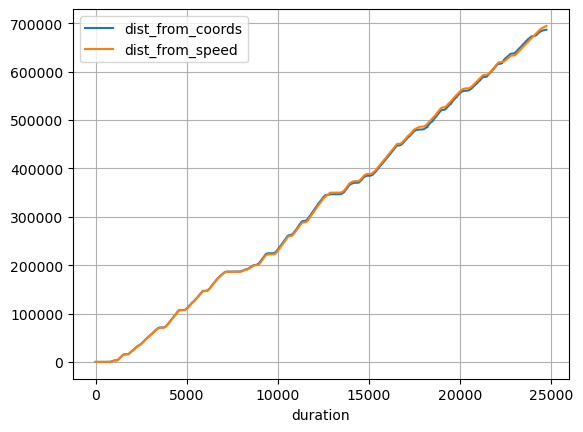

In [30]:
ax = data.plot("duration", "dist_from_coords")
data.plot("duration", "dist_from_speed", ax=ax)
ax.grid()
plt.show()

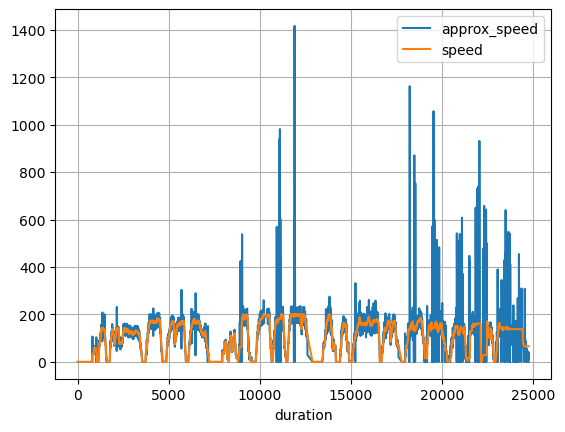

In [31]:
ax = data.plot("duration", "approx_speed")
data.plot("duration", "speed", ax=ax)
ax.grid()
plt.show()

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4028 entries, 0 to 4027
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   timestamp           4028 non-null   datetime64[ns, UTC]
 1   speed               4028 non-null   int64              
 2   accuracy            4028 non-null   int64              
 3   duration            4028 non-null   float64            
 4   latitude            4028 non-null   float64            
 5   longitude           4028 non-null   float64            
 6   previous_latitude   4028 non-null   float64            
 7   previous_longitude  4028 non-null   float64            
 8   change_of_location  4028 non-null   float64            
 9   dist_from_coords    4028 non-null   float64            
 10  dist_from_speed     4028 non-null   float64            
 11  approx_speed        4028 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64

In [33]:
data.describe()

,speed,accuracy,duration,latitude,longitude,previous_latitude,previous_longitude,change_of_location,dist_from_coords,dist_from_speed,approx_speed
count,4028.000000,4028.000000,4028.000000,4028.000000,4028.000000,4028.000000,4028.000000,4028.000000,4028.000000,4028.000000,4028.000000
mean,100.611470,2.493545,12342.408888,62.515112,24.000835,62.513911,24.000700,170.546463,323555.584344,324223.674142,101.093897
std,65.755054,1.635133,7216.200055,1.489313,0.884716,1.489251,0.884532,198.443615,209690.229488,210773.958396,93.076712
min,0.000000,0.000000,0.000000,60.173204,22.642876,60.173204,22.642876,0.000000,0.000000,0.000000,0.000000
25%,35.000000,1.000000,6040.500000,61.170858,23.052901,61.170856,23.052901,29.570005,146979.929743,146454.444444,17.783687
50%,122.000000,3.000000,12219.000000,62.627196,23.819133,62.623961,23.819133,181.164659,326707.647835,323596.111111,108.173884
75%,156.000000,4.000000,18705.500000,63.869311,24.918588,63.869290,24.918588,261.851256,507911.969751,512648.888889,156.824734
max,203.000000,5.000000,24746.000000,65.011975,25.524686,65.011975,25.524686,7735.186402,686961.151102,694717.222222,1415.761835


### Outlierien metsästys

In [89]:
# data[data["approx_speed"] == data["approx_speed"].max()]
data.iloc[1956:1964, :]

,timestamp,speed,accuracy,duration,latitude,longitude,previous_latitude,previous_longitude,change_of_location,dist_from_coords,dist_from_speed,approx_speed,acceleration,acceleration+
1956,2023-03-14 06:08:24+00:00,192,0,11874.0,62.449822,22.954644,62.449822,22.954644,0.000000,306928.339157,304712.777778,0.000000,0.000000,0.000000
1957,2023-03-14 06:08:30+00:00,192,0,11880.0,62.449822,22.954644,62.449822,22.954644,0.000000,306928.339157,305032.777778,0.000000,0.000000,0.000000
1958,2023-03-14 06:08:36+00:00,192,0,11886.0,62.449822,22.954644,62.449822,22.954644,0.000000,306928.339157,305352.777778,0.000000,0.000000,0.000000
1959,2023-03-14 06:08:42+00:00,192,0,11892.0,62.449822,22.954644,62.449822,22.954644,0.000000,306928.339157,305672.777778,0.000000,0.000000,0.000000
1960,2023-03-14 06:08:48+00:00,192,0,11898.0,62.449822,22.954644,62.449822,22.954644,0.000000,306928.339157,305992.777778,1415.761835,0.000000,0.000000
1961,2023-03-14 06:08:54+00:00,192,0,11904.0,62.471029,22.956276,62.449822,22.954644,2359.603059,309287.942215,306312.777778,55.065593,0.000000,0.000000
1962,2023-03-14 06:09:00+00:00,192,0,11910.0,62.471851,22.956437,62.471029,22.956276,91.775988,309379.718203,306632.777778,0.000000,0.000000,0.000000
1963,2023-03-14 06:09:06+00:00,192,0,11916.0,62.471851,22.956437,62.471851,22.956437,0.000000,309379.718203,306952.777778,596.373775,0.509259,0.509259


In [88]:
data.iloc[1705:1713, :]

,timestamp,speed,accuracy,duration,latitude,longitude,previous_latitude,previous_longitude,change_of_location,dist_from_coords,dist_from_speed,approx_speed,acceleration,acceleration+
1705,2023-03-14 05:41:00+00:00,195,4,10230.0,61.907804,23.237723,61.905632,23.240125,272.303212,243770.627969,241269.444444,201.755705,0.231481,0.231481
1706,2023-03-14 05:41:06+00:00,200,4,10236.0,61.910501,23.234818,61.907804,23.237723,336.259509,244106.887477,241594.444444,198.853480,-0.046296,0.000000
1707,2023-03-14 05:41:12+00:00,199,4,10242.0,61.913155,23.231937,61.910501,23.234818,331.422467,244438.309944,241927.777778,199.989472,0.046296,0.046296
1708,2023-03-14 05:41:18+00:00,200,4,10248.0,61.915805,23.228961,61.913155,23.231937,333.315786,244771.625731,242259.444444,193.379660,-0.007716,0.000000
1709,2023-03-14 05:43:42+00:00,196,4,10392.0,61.975994,23.154801,61.915805,23.228961,7735.186402,252506.812132,250259.444444,191.634851,-0.185185,0.000000
1710,2023-03-14 05:43:48+00:00,192,4,10398.0,61.978438,23.151589,61.975994,23.154801,319.391418,252826.203550,250586.111111,191.072302,0.046296,0.046296
1711,2023-03-14 05:43:54+00:00,193,4,10404.0,61.980904,23.148489,61.978438,23.151589,318.453836,253144.657386,250906.111111,192.700649,-0.138889,0.000000
1712,2023-03-14 05:44:00+00:00,190,4,10410.0,61.983397,23.145384,61.980904,23.148489,321.167748,253465.825134,251227.777778,223.195582,0.000000,0.000000


In [35]:
data.sort_values("change_of_location", ascending=False).head(10)

,timestamp,speed,accuracy,duration,latitude,longitude,previous_latitude,previous_longitude,change_of_location,dist_from_coords,dist_from_speed,approx_speed
1709,2023-03-14 05:43:42+00:00,196,4,10392.0,61.975994,23.154801,61.915805,23.228961,7735.186402,252506.812132,250259.444444,191.634851
1961,2023-03-14 06:08:54+00:00,192,0,11904.0,62.471029,22.956276,62.449822,22.954644,2359.603059,309287.942215,306312.777778,55.065593
2079,2023-03-14 06:25:11+00:00,0,4,12881.0,62.792191,22.843426,62.778016,22.875470,2267.093992,346639.735814,349937.222222,0.000000
2940,2023-03-14 07:54:14+00:00,133,0,18224.0,63.842923,23.267712,63.836998,23.230580,1935.900904,487380.039065,492587.222222,285.916603
3158,2023-03-14 08:16:02+00:00,143,0,19532.0,63.931357,24.188211,63.919589,24.164113,1760.524955,536076.913294,540400.277778,193.156140
1827,2023-03-14 05:55:30+00:00,181,0,11100.0,62.198281,23.028071,62.183985,23.035451,1635.092858,278627.439284,275606.111111,64.275955
1823,2023-03-14 05:55:06+00:00,181,0,11076.0,62.183985,23.035451,62.169997,23.038861,1565.430681,276992.346425,274399.444444,0.000000
3577,2023-03-14 08:57:56+00:00,162,0,22046.0,64.479180,24.991829,64.465329,24.987895,1551.655030,615407.070367,616256.111111,126.476551
2982,2023-03-14 07:58:26+00:00,143,0,18476.0,63.861277,23.469904,63.856741,23.442146,1450.401033,498151.329922,503010.555556,114.560759
3560,2023-03-14 08:56:15+00:00,162,0,21945.0,64.436415,24.982744,64.423730,24.978754,1423.446938,610621.936194,611711.111111,197.686258


In [36]:
data[data["change_of_location"] != 0].sort_values("change_of_location").head(10)

,timestamp,speed,accuracy,duration,latitude,longitude,previous_latitude,previous_longitude,change_of_location,dist_from_coords,dist_from_speed,approx_speed
2702,2023-03-14 07:27:34+00:00,0,4,16624.0,63.596233,22.792095,63.596241,22.792093,0.895040,447632.065470,451039.166667,0.000000
2422,2023-03-14 06:59:34+00:00,0,3,14944.0,63.100633,23.034392,63.100634,23.034411,0.962286,384989.915402,388448.055556,0.603480
785,2023-03-14 04:09:00+00:00,0,3,4710.0,61.002818,24.477982,61.002818,24.477964,0.970265,107249.523859,106894.444444,0.600453
1752,2023-03-14 05:48:00+00:00,3,3,10650.0,62.052563,23.078209,62.052563,23.078228,0.990143,262009.683656,260022.777778,2.411305
271,2023-03-14 03:17:36+00:00,0,3,1626.0,60.293589,25.044929,60.293589,25.044911,0.991859,15702.685901,15477.777778,0.000000
2698,2023-03-14 07:27:10+00:00,0,4,16600.0,63.596241,22.792093,63.596242,22.792113,0.995186,447631.170430,451039.166667,0.000000
786,2023-03-14 04:09:06+00:00,0,2,4716.0,61.002827,24.477982,61.002818,24.477982,1.000754,107250.524614,106894.444444,0.000000
2128,2023-03-14 06:30:03+00:00,0,5,13173.0,62.792200,22.843425,62.792191,22.843426,1.002045,346640.737859,349937.222222,0.000000
1894,2023-03-14 06:02:12+00:00,0,4,11502.0,62.314414,22.986577,62.314423,22.986576,1.002087,291753.898418,288909.444444,3.036112
1613,2023-03-14 05:31:48+00:00,0,3,9678.0,61.751379,23.388168,61.751370,23.388169,1.002137,224629.132062,222342.222222,0.000000


In [37]:
data[data["speed"] > 0].head()

,timestamp,speed,accuracy,duration,latitude,longitude,previous_latitude,previous_longitude,change_of_location,dist_from_coords,dist_from_speed,approx_speed
135,2023-03-14 03:04:00+00:00,27,2,810.0,60.174798,24.941134,60.173204,24.941432,178.009285,178.009285,0.000000,40.204459
136,2023-03-14 03:04:06+00:00,35,3,816.0,60.175394,24.941313,60.174798,24.941134,67.007432,245.016718,45.000000,36.746277
137,2023-03-14 03:04:12+00:00,35,4,822.0,60.175939,24.941153,60.175394,24.941313,61.243794,306.260512,103.333333,29.954529
138,2023-03-14 03:04:18+00:00,28,4,828.0,60.176366,24.940874,60.175939,24.941153,49.924214,356.184726,161.666667,35.765441
139,2023-03-14 03:04:24+00:00,31,4,834.0,60.176883,24.940589,60.176366,24.940874,59.609068,415.793794,208.333333,32.469335


In [38]:
data[data["speed"] > 0].tail()

,timestamp,speed,accuracy,duration,latitude,longitude,previous_latitude,previous_longitude,change_of_location,dist_from_coords,dist_from_speed,approx_speed
4023,2023-03-14 09:42:32+00:00,66,0,24722.0,65.010316,25.484182,65.010681,25.483864,43.247848,686819.632699,694277.222222,33.145203
4024,2023-03-14 09:42:38+00:00,66,0,24728.0,65.010795,25.484494,65.010316,25.484182,55.242005,686874.874704,694387.222222,11.017762
4025,2023-03-14 09:42:44+00:00,66,0,24734.0,65.010667,25.484247,65.010795,25.484494,18.362937,686893.237641,694497.222222,40.748076
4026,2023-03-14 09:42:50+00:00,66,0,24740.0,65.010079,25.483856,65.010667,25.484247,67.913460,686961.151102,694607.222222,0.000000
4027,2023-03-14 09:42:56+00:00,66,0,24746.0,65.010079,25.483856,65.010079,25.483856,0.000000,686961.151102,694717.222222,0.000000


In [39]:
data[data["speed"] > 200]

,timestamp,speed,accuracy,duration,latitude,longitude,previous_latitude,previous_longitude,change_of_location,dist_from_coords,dist_from_speed,approx_speed
1514,2023-03-14 05:21:54+00:00,201,4,9084.0,61.633658,23.521785,61.630343,23.523933,385.684848,209618.786521,207010.555556,198.513494
1704,2023-03-14 05:40:54+00:00,201,4,10224.0,61.905632,23.240125,61.902933,23.242991,335.550382,243498.324757,240934.444444,163.381927
1928,2023-03-14 06:05:36+00:00,203,2,11706.0,62.376771,22.967099,62.373305,22.968127,389.029172,298763.568414,295537.777778,193.292333
1929,2023-03-14 06:05:42+00:00,203,2,11712.0,62.379613,22.965885,62.376771,22.967099,322.153888,299085.722302,295876.111111,196.555781
1951,2023-03-14 06:07:54+00:00,201,0,11844.0,62.443332,22.955270,62.440108,22.955997,360.438064,306205.391475,303086.111111,195.753735
1964,2023-03-14 06:09:12+00:00,203,1,11922.0,62.480754,22.954706,62.471851,22.956437,993.956291,310373.674494,307272.777778,234.630223
1965,2023-03-14 06:09:18+00:00,201,2,11928.0,62.484265,22.954269,62.480754,22.954706,391.050371,310764.724865,307611.111111,190.984684
1968,2023-03-14 06:09:36+00:00,202,3,11946.0,62.493198,22.953290,62.490033,22.953545,352.175537,311759.758130,308599.444444,191.597413
1978,2023-03-14 06:10:36+00:00,202,3,12006.0,62.522651,22.947578,62.519662,22.948043,333.216843,315048.012128,311887.777778,194.094139
1994,2023-03-14 06:12:12+00:00,201,1,12102.0,62.569585,22.940286,62.566531,22.940372,339.617881,320291.094531,317169.444444,191.713290


In [40]:
data[data["approx_speed"] > 210]

,timestamp,speed,accuracy,duration,latitude,longitude,previous_latitude,previous_longitude,change_of_location,dist_from_coords,dist_from_speed,approx_speed
357,2023-03-14 03:26:12+00:00,138,3,2142.0,60.389153,25.100811,60.388475,25.100542,76.825207,26823.620287,26482.777778,231.417005
691,2023-03-14 03:59:36+00:00,169,4,4146.0,60.864703,24.705167,60.863110,24.706000,182.784327,86418.285996,85959.444444,225.469550
949,2023-03-14 04:25:24+00:00,171,4,5694.0,61.131214,23.998242,61.130507,23.999201,93.973357,138027.028602,137502.777778,303.616438
1041,2023-03-14 04:34:36+00:00,150,4,6246.0,61.192384,23.793205,61.191590,23.794943,128.325098,151373.402256,150764.444444,223.496733
1054,2023-03-14 04:35:54+00:00,169,3,6324.0,61.220889,23.764271,61.218492,23.765858,279.747618,154950.195668,154197.777778,211.059141
...,...,...,...,...,...,...,...,...,...,...,...,...
3887,2023-03-14 09:28:56+00:00,138,0,23906.0,64.903094,25.510946,64.903094,25.510946,0.000000,672248.143358,668700.833333,238.384950
3927,2023-03-14 09:32:56+00:00,138,0,24146.0,64.920186,25.509554,64.920186,25.509554,0.000000,674569.835256,677900.833333,269.067029
3938,2023-03-14 09:34:02+00:00,138,0,24212.0,64.932268,25.524116,64.932268,25.524116,0.000000,676170.454227,680430.833333,454.460664
3961,2023-03-14 09:36:20+00:00,138,0,24350.0,64.971383,25.495666,64.971383,25.495666,0.000000,680879.115885,685720.833333,309.404398


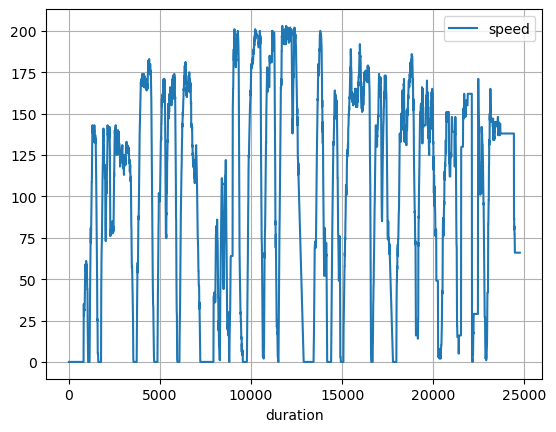

In [78]:
ax = data.plot("duration", "speed")
# data.plot("duration", "approx_speed", ax=ax)
# ax.set_ylim(0, 200)
plt.grid()
plt.show()

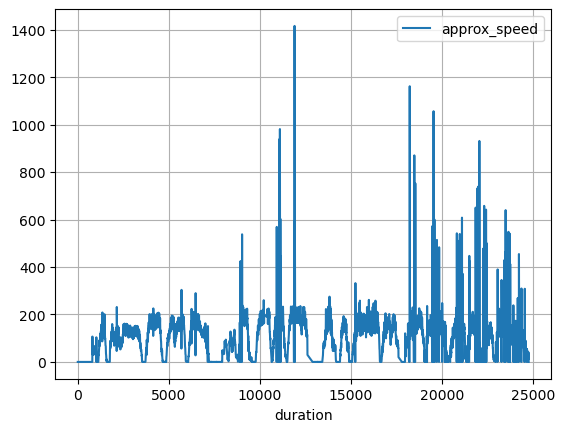

In [75]:
data.plot("duration", "approx_speed")
plt.grid()
plt.show()

## Kiihdytään

In [42]:
def get_acceleration(speeds, durations):
    speed_diff = speeds[1:].to_numpy() - speeds[:-1].to_numpy()
    time_diff = durations[1:].to_numpy() - durations[:-1].to_numpy()
    # print(len(speed_diff), len(speeds))
    # td = pd.Series(timestamps[1:]).reset_index() - pd.Series(timestamps[:-1]).reset_index()
    # print(td[:3])
    # time_diff = timestamps[1:].reset_index(drop=True) - timestamps[:-1].reset_index(drop=True)
    # time_diff = time_diff.apply(lambda ts: ts.total_seconds())
    # print(len(time_diff), len(timestamps))
    accel = list(speed_diff / time_diff / 3.6)
    accel.append(0)
    return accel

In [43]:
data["acceleration"] = get_acceleration(data["speed"], data["duration"])
data["acceleration+"] = data["acceleration"].apply(lambda a: max(a, 0))

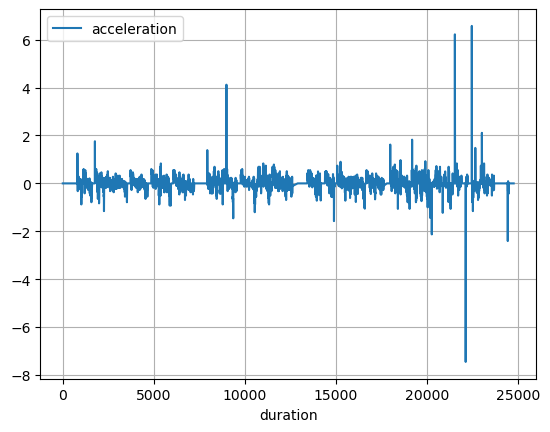

In [44]:
data.plot("duration", "acceleration")
plt.grid()
plt.show()

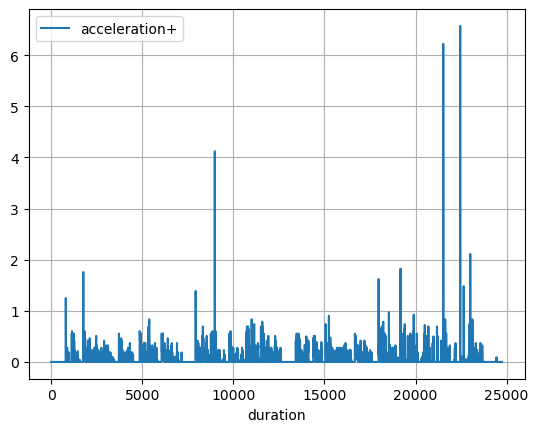

In [45]:
data.plot("duration", "acceleration+")
plt.grid()
plt.show()

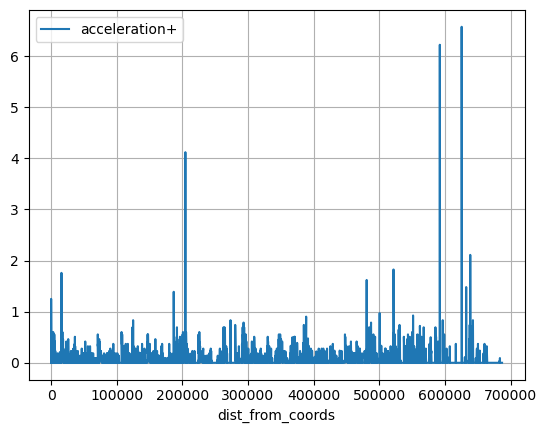

In [73]:
data.plot("dist_from_coords", "acceleration+")
plt.grid()
plt.show()

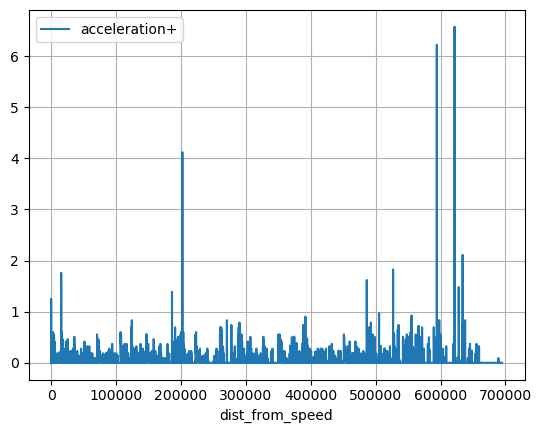

In [74]:
data.plot("dist_from_speed", "acceleration+")
plt.grid()
plt.show()

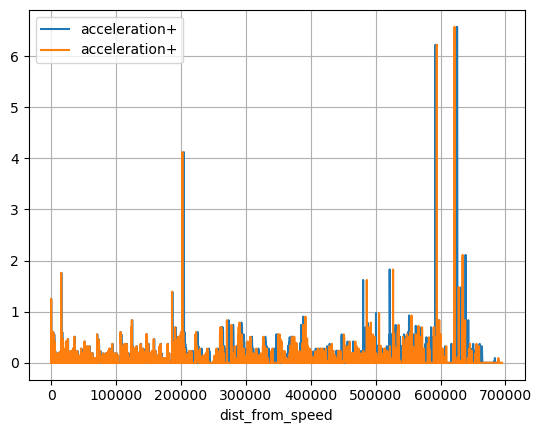

In [72]:

ax = data.plot("dist_from_coords", "acceleration+")
data.plot("dist_from_speed", "acceleration+", ax=ax)
ax.grid()
plt.show()

In [47]:
data.describe()

,speed,accuracy,duration,latitude,longitude,previous_latitude,previous_longitude,change_of_location,dist_from_coords,dist_from_speed,approx_speed,acceleration,acceleration+
count,4028.000000,4028.000000,4028.000000,4028.000000,4028.000000,4028.000000,4028.000000,4028.000000,4028.000000,4028.000000,4028.000000,4028.000000,4028.000000
mean,100.611470,2.493545,12342.408888,62.515112,24.000835,62.513911,24.000700,170.546463,323555.584344,324223.674142,101.093897,0.003126,0.072062
std,65.755054,1.635133,7216.200055,1.489313,0.884716,1.489251,0.884532,198.443615,209690.229488,210773.958396,93.076712,0.306498,0.212596
min,0.000000,0.000000,0.000000,60.173204,22.642876,60.173204,22.642876,0.000000,0.000000,0.000000,0.000000,-7.453704,0.000000
25%,35.000000,1.000000,6040.500000,61.170858,23.052901,61.170856,23.052901,29.570005,146979.929743,146454.444444,17.783687,-0.046296,0.000000
50%,122.000000,3.000000,12219.000000,62.627196,23.819133,62.623961,23.819133,181.164659,326707.647835,323596.111111,108.173884,0.000000,0.000000
75%,156.000000,4.000000,18705.500000,63.869311,24.918588,63.869290,24.918588,261.851256,507911.969751,512648.888889,156.824734,0.092593,0.092593
max,203.000000,5.000000,24746.000000,65.011975,25.524686,65.011975,25.524686,7735.186402,686961.151102,694717.222222,1415.761835,6.574074,6.574074


In [48]:
data["acceleration"].quantile(0.95)

0.37037037037037035

In [49]:
data[abs(data["acceleration"]) > 0.5]

,timestamp,speed,accuracy,duration,latitude,longitude,previous_latitude,previous_longitude,change_of_location,dist_from_coords,dist_from_speed,approx_speed,acceleration,acceleration+
134,2023-03-14 03:03:54+00:00,0,1,804.0,60.173204,24.941432,60.173204,24.941432,0.000000,0.000000,0.000000,106.805571,1.250000,1.250000
170,2023-03-14 03:07:30+00:00,44,3,1020.0,60.198154,24.934348,60.198154,24.934348,0.000000,2825.938093,2736.666667,103.637999,-0.879630,0.000000
174,2023-03-14 03:07:54+00:00,12,4,1044.0,60.200429,24.933375,60.200233,24.933496,22.796860,3085.881101,2911.666667,2.983313,-0.555556,0.000000
189,2023-03-14 03:09:24+00:00,0,4,1134.0,60.200463,24.933283,60.200463,24.933283,0.000000,3097.441097,2931.666667,10.847945,0.555556,0.555556
191,2023-03-14 03:09:36+00:00,13,3,1146.0,60.200909,24.933075,60.200625,24.933255,33.108815,3148.629820,2951.666667,30.102809,0.601852,0.601852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3751,2023-03-14 09:15:20+00:00,136,1,23090.0,64.688203,25.148693,64.685929,25.145619,292.054005,641442.414814,636533.055556,146.715717,0.648148,0.648148
3756,2023-03-14 09:15:51+00:00,150,0,23121.0,64.696843,25.162828,64.695297,25.160478,205.003434,642616.943735,637794.722222,224.386186,0.833333,0.833333
3783,2023-03-14 09:18:32+00:00,147,1,23282.0,64.745476,25.246645,64.743870,25.243639,228.534371,649352.659362,644422.222222,105.039229,-0.509259,0.000000
3828,2023-03-14 09:23:02+00:00,148,0,23552.0,64.805419,25.412840,64.804035,25.410163,199.351447,659949.359435,655092.500000,157.877075,-0.509259,0.000000


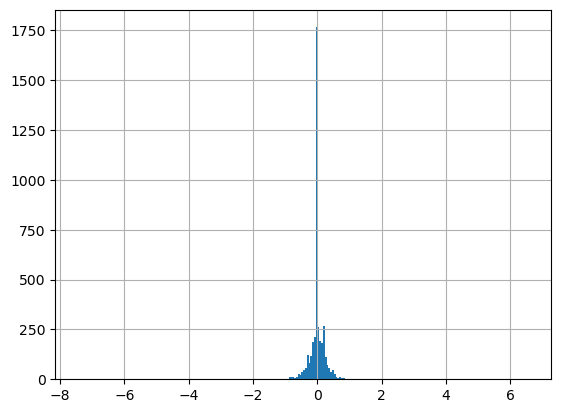

In [50]:
# data["acceleration"].plot.hist(density=True)
data["acceleration"].hist(bins=250)
plt.show()

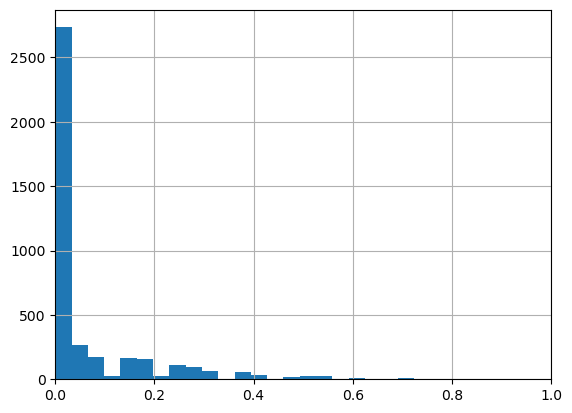

In [51]:
data["acceleration+"].hist(bins=200)
plt.xlim(0, 1)
plt.show()

In [52]:
# data = data.set_index("duration").sort_index()

In [53]:
data.head()

,timestamp,speed,accuracy,duration,latitude,longitude,previous_latitude,previous_longitude,change_of_location,dist_from_coords,dist_from_speed,approx_speed,acceleration,acceleration+
0,2023-03-14 02:50:30+00:00,0,4,0.0,60.173204,24.941432,60.173204,24.941432,0.0,0.0,0.0,0.0,0.0,0.0
1,2023-03-14 02:50:36+00:00,0,4,6.0,60.173204,24.941432,60.173204,24.941432,0.0,0.0,0.0,0.0,0.0,0.0
2,2023-03-14 02:50:42+00:00,0,4,12.0,60.173204,24.941432,60.173204,24.941432,0.0,0.0,0.0,0.0,0.0,0.0
3,2023-03-14 02:50:48+00:00,0,4,18.0,60.173204,24.941432,60.173204,24.941432,0.0,0.0,0.0,0.0,0.0,0.0
4,2023-03-14 02:50:54+00:00,0,4,24.0,60.173204,24.941432,60.173204,24.941432,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
data[abs(data["acceleration"]) > 0.5].index

Int64Index([ 134,  170,  174,  189,  191,  197,  206,  252,  258,  259,
            ...
            3727, 3736, 3740, 3743, 3746, 3751, 3756, 3783, 3828, 3973],
           dtype='int64', length=211)

In [55]:
indekseja = [list(data.index).index(item) for item in data[abs(data["acceleration"]) > 0.5].index]

In [56]:
len(indekseja)

211

In [57]:
extra = [i + 1 for i in indekseja]
indekseja = indekseja + extra
indekseja.sort()

In [58]:
indekseja[:10]

[134, 135, 170, 171, 174, 175, 189, 190, 191, 192]

In [59]:
data.iloc[indekseja, :]

,timestamp,speed,accuracy,duration,latitude,longitude,previous_latitude,previous_longitude,change_of_location,dist_from_coords,dist_from_speed,approx_speed,acceleration,acceleration+
134,2023-03-14 03:03:54+00:00,0,1,804.0,60.173204,24.941432,60.173204,24.941432,0.000000,0.000000,0.000000,106.805571,1.250000,1.250000
135,2023-03-14 03:04:00+00:00,27,2,810.0,60.174798,24.941134,60.173204,24.941432,178.009285,178.009285,0.000000,40.204459,0.370370,0.370370
170,2023-03-14 03:07:30+00:00,44,3,1020.0,60.198154,24.934348,60.198154,24.934348,0.000000,2825.938093,2736.666667,103.637999,-0.879630,0.000000
171,2023-03-14 03:07:36+00:00,25,2,1026.0,60.199692,24.933909,60.198154,24.934348,172.729999,2998.668091,2810.000000,21.210673,-0.185185,0.000000
174,2023-03-14 03:07:54+00:00,12,4,1044.0,60.200429,24.933375,60.200233,24.933496,22.796860,3085.881101,2911.666667,2.983313,-0.555556,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3784,2023-03-14 09:18:38+00:00,136,1,23288.0,64.746506,25.249436,64.745476,25.246645,175.065382,649527.724743,644667.222222,134.370848,-0.092593,0.000000
3828,2023-03-14 09:23:02+00:00,148,0,23552.0,64.805419,25.412840,64.804035,25.410163,199.351447,659949.359435,655092.500000,157.877075,-0.509259,0.000000
3829,2023-03-14 09:23:08+00:00,137,0,23558.0,64.807190,25.416527,64.805419,25.412840,263.128459,660212.487893,655339.166667,167.279152,0.370370,0.370370
3973,2023-03-14 09:37:32+00:00,138,0,24422.0,64.990455,25.478946,64.989260,25.478717,133.313322,683272.673711,688480.833333,93.026507,-2.407407,0.000000


In [60]:
# data.loc[0, "location"]

In [61]:
# def get_coordinates(row):
#     return tuple(row["location"]["coordinates"])

In [62]:
# data["coord1"] = data["location"].apply(lambda x: x["coordinates"][0])
# data["coord2"] = data["location"].apply(lambda x: x["coordinates"][1])

In [63]:
data.iloc[130:150, :]

,timestamp,speed,accuracy,duration,latitude,longitude,previous_latitude,previous_longitude,change_of_location,dist_from_coords,dist_from_speed,approx_speed,acceleration,acceleration+
130,2023-03-14 03:03:30+00:00,0,3,780.0,60.173204,24.941432,60.173204,24.941432,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
131,2023-03-14 03:03:36+00:00,0,3,786.0,60.173204,24.941432,60.173204,24.941432,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
132,2023-03-14 03:03:42+00:00,0,2,792.0,60.173204,24.941432,60.173204,24.941432,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
133,2023-03-14 03:03:48+00:00,0,1,798.0,60.173204,24.941432,60.173204,24.941432,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
134,2023-03-14 03:03:54+00:00,0,1,804.0,60.173204,24.941432,60.173204,24.941432,0.000000,0.000000,0.000000,106.805571,1.250000,1.250000
135,2023-03-14 03:04:00+00:00,27,2,810.0,60.174798,24.941134,60.173204,24.941432,178.009285,178.009285,0.000000,40.204459,0.370370,0.370370
136,2023-03-14 03:04:06+00:00,35,3,816.0,60.175394,24.941313,60.174798,24.941134,67.007432,245.016718,45.000000,36.746277,0.000000,0.000000
137,2023-03-14 03:04:12+00:00,35,4,822.0,60.175939,24.941153,60.175394,24.941313,61.243794,306.260512,103.333333,29.954529,-0.324074,0.000000
138,2023-03-14 03:04:18+00:00,28,4,828.0,60.176366,24.940874,60.175939,24.941153,49.924214,356.184726,161.666667,35.765441,0.138889,0.138889
139,2023-03-14 03:04:24+00:00,31,4,834.0,60.176883,24.940589,60.176366,24.940874,59.609068,415.793794,208.333333,32.469335,0.000000,0.000000


In [64]:
# data.apply(get_coordinates, axis=1)

In [65]:
data.loc[[804, 810], :]

,timestamp,speed,accuracy,duration,latitude,longitude,previous_latitude,previous_longitude,change_of_location,dist_from_coords,dist_from_speed,approx_speed,acceleration,acceleration+
804,2023-03-14 04:10:54+00:00,0,1,4824.0,61.002827,24.477963,61.002827,24.477963,0.0,107253.597117,106894.444444,0.614501,0.000000,0.000000
810,2023-03-14 04:11:30+00:00,0,4,4860.0,61.002827,24.477963,61.002827,24.477963,0.0,107257.693789,106894.444444,16.091467,0.601852,0.601852


### Etäisyyslaskentaa koordinaateista

In [66]:
# maapallon säde metreinä
R = 6_371_000

lat1 = 60.173204
lon1 = 24.941432
lat2 = 60.174798
lon2 = 24.941134



In [67]:
lat1_r = lat1 * np.pi / 180
lon1_r = lon1 * np.pi / 180
lat2_r = lat2 * np.pi / 180
lon2_r = lon2 * np.pi / 180


lat_mean_r = (lat1_r + lat2_r) / 2
lat_diff_r = (lat2 - lat1) * np.pi / 180
lon_diff_r = (lon2 - lon1) * np.pi / 180


In [68]:
# pyttis
x = lon_diff_r * np.cos(lat_mean_r)
y = lat_diff_r
# etäisyys
R * np.sqrt(x*x + y*y)

178.00928545949063

In [69]:
def coords_to_distance_w_pyttis(latitude1, longitude1, latitude2, longitude2):
    R = 6_371_000
    
    lat_mean_r = (latitude1 + latitude2) / 2 * np.pi / 180
    lat_diff_r = (latitude2 - latitude1) * np.pi / 180
    lon_diff_r = (longitude2 - longitude1) * np.pi / 180
    
    x = lon_diff_r * np.cos(lat_mean_r)
    y = lat_diff_r
    
    return R * np.sqrt(x*x + y*y)

In [70]:
# spherical law of cosines
R * np.arccos(np.sin(lat1_r) * np.sin(lat2_r) + np.cos(lat1_r) * np.cos(lat2_r) * np.cos(lon_diff_r))

178.0092784576834

In [71]:
# haversine
a = np.sin(lat_diff_r / 2)**2 + np.cos(lat1_r) * np.cos(lat2_r) * np.sin(lon_diff_r / 2)**2
c = 2 * np.arctan(min(np.sqrt(a), np.sqrt(1 - a)))
R * c

178.00928544162008